In [1]:
import json
import os
import re
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import ray

from rl_trading.simulation.env import StockExchangeEnv0
from rl_trading.data.indicators import *

root_dir = '../exp_results/baseline_correct'

In [2]:
state_config = {
        'market_state': ['vwap'],
        'technical_indicators': [
            (RPC, {}, '1min'),
            (EMA, dict(timeperiod=5, normalize=True), '1min'),
            (EMA, dict(timeperiod=13, normalize=True), '1min'),
            (RSI, dict(timeperiod=7, normalize=True), '1min'),
            (BBANDS, dict(timeperiod=10), '1min'),
            (EMA, dict(timeperiod=20, normalize=True), '1h'),
            (EMA, dict(timeperiod=50, normalize=True), '1h'),
            (RSI, dict(timeperiod=14, normalize=True), '1h'),
            (BBANDS, dict(timeperiod=20), '1h'),
            (MACD_DIFF, dict(fastperiod=12, slowperiod=26, signalperiod=9, normalize=True), '1h'),
            (EMA, dict(timeperiod=50, normalize=True), '1d'),
            (EMA, dict(timeperiod=200, normalize=True), '1d'),
            (RSI, dict(timeperiod=14, normalize=True), '1d'),
            (BBANDS, dict(timeperiod=20), '1d'),
            (MACD_DIFF, dict(fastperiod=12, slowperiod=26, signalperiod=9, normalize=True), '1d'),
        ]}

In [7]:
from rl_trading.utils import load_model
from tqdm import tqdm

ray.logger.setLevel('ERROR')

def load_checkpoints():
    checkpoints = {}
    for alg_name in os.listdir(root_dir):
        checkpoints[alg_name] = {}
        for exp_name in os.listdir(os.path.join(root_dir, alg_name)):
            seed = int(re.findall('seed=([0-9]+)', exp_name)[0])
            checkpoints[alg_name][seed] = {}
            for result_dir in os.listdir(os.path.join(root_dir, alg_name, exp_name)):
                if 'steps' in result_dir:
                    sequence_len = int(re.findall('steps=([0-9]+)', result_dir)[0])
                elif 'days' in result_dir:
                    sequence_len = int(re.findall('days=([0-9]+)', result_dir)[0]) * 1440
                else:
                    continue

                for file in os.listdir(os.path.join(root_dir, alg_name, exp_name, result_dir)):
                    if 'checkpoint' in file:
                       checkpoints[alg_name][seed][sequence_len] = os.path.join(root_dir, alg_name, exp_name, result_dir, file)
    return checkpoints

def evaluate_policies(checkpoints):
    eval_results = {}
    for alg_name in checkpoints:
        eval_results[alg_name] = {}
        for seed in checkpoints[alg_name]:
            eval_results[alg_name][seed] = {}
            print(f'Evaluating alg: {alg_name}')
            for sequence_len, checkpoint in checkpoints[alg_name][seed].items():
                max_steps = sequence_len if sequence_len < 1440 else 1440
                n_days = 1 if sequence_len < 1440 else sequence_len // 1440
                model = load_model(checkpoint)

                sim_env = StockExchangeEnv0(
                    sim_config={'max_steps': max_steps},
                    state_config=state_config,
                    _n_days=n_days,
                    seed=seed
                )
                eval_env = StockExchangeEnv0(
                    sim_config={'max_steps': max_steps},
                    state_config=state_config,
                    _n_days=n_days,
                    seed=seed
                )
                model_results = []
                baseline_results = []
                for i in tqdm(range(10)):
                    sim_env.reset()
                    eval_env.reset()
                    sim_env.start_idx = sim_env._idxs_range[0] + 1440 * (i + 1)
                    eval_env.start_idx = sim_env._idxs_range[0] + 1440 * (i + 1)
                    state = sim_env._get_observation()

                    done = False
                    reward_total = 0
                    baseline_reward = 0
                    rnn_state = [np.zeros([256], np.float32) for _ in range(2)]
                    prev_action, prev_reward = 0, 0

                    while not done:
                        current_idx = eval_env.current_idx
                        current_price = eval_env.price_data['1min'][current_idx]
                        next_price = eval_env.price_data['1min'][current_idx + 1]
                        if next_price > current_price:
                            action = 1
                        elif next_price < current_price:
                            action = 2
                        else:
                            action = 0
                        _, reward, done, _, _ = eval_env.step(action)
                        baseline_reward += reward

                        if 'R2D2' in alg_name:
                            action, rnn_state, _ = model.compute_single_action(state, state=rnn_state, prev_action=prev_action, prev_reward=prev_reward, explore=False)
                        else:
                            action = model.compute_single_action(state, explore=False)
                        state, reward, done, _, _ = sim_env.step(action)
                        prev_action = action
                        prev_reward = reward
                        reward_total += reward
                    model_results.append(reward_total)
                    baseline_results.append(baseline_reward)
                print('sequence len:', sequence_len)
                print('baseline_reward:', np.mean(baseline_results))
                print('reward_total:', np.mean(model_results))
                eval_results[alg_name][seed][sequence_len] = (np.mean(model_results), np.mean(baseline_results))
                del model
    return eval_results

In [8]:
checkpoints = load_checkpoints()
eval_results = evaluate_policies(checkpoints)

Evaluating alg: R2D2


/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprec

sequence len: 2102400
baseline_reward: 7263.522016184678
reward_total: 1074.2115161646302


(RolloutWorker pid=2592637) 2023-06-18 00:08:41,247	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:12<00:00,  7.22s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 15840
baseline_reward: 3322.881782719164
reward_total: 370.0878576125577


(RolloutWorker pid=2607180) 2023-06-18 00:10:05,222	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:30<00:00,  3.03s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 600
baseline_reward: 927.5670131544164
reward_total: 40.099765481496796


(RolloutWorker pid=2614586) 2023-06-18 00:10:47,570	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:13<00:00,  7.35s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 7200
baseline_reward: 2545.6323995372595
reward_total: 235.81270430665063


(RolloutWorker pid=2629630) 2023-06-18 00:12:12,908	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:13<00:00,  7.39s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 1440
baseline_reward: 2134.091883303759
reward_total: 155.50068275807536


(RolloutWorker pid=2644831) 2023-06-18 00:13:38,641	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:14<00:00,  7.42s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 934560
baseline_reward: 13172.094477343993
reward_total: 835.1095594655292


(RolloutWorker pid=2660221) 2023-06-18 00:15:04,773	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:00<00:00, 17.66it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 10
baseline_reward: 9.285897185086833
reward_total: 0.14624032036499557


(RolloutWorker pid=2662576) 2023-06-18 00:15:17,453	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:14<00:00,  7.48s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 82080
baseline_reward: 3550.8147722642743
reward_total: 568.3296207170746


(RolloutWorker pid=2678360) 2023-06-18 00:16:44,145	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:14<00:00,  7.47s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 184320
baseline_reward: 9747.059277856317
reward_total: 209.1229684047881


(RolloutWorker pid=2694213) 2023-06-18 00:18:11,152	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:03<00:00,  3.09it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 60
baseline_reward: 70.95029108541311
reward_total: 6.259203796133806


(RolloutWorker pid=2697159) 2023-06-18 00:18:26,429	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:14<00:00,  7.50s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 36000
baseline_reward: 4244.213405033889
reward_total: 698.6843742403232


(RolloutWorker pid=2713254) 2023-06-18 00:19:53,560	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:01<00:00,  5.98it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 30
baseline_reward: 35.37353615480406
reward_total: 3.4749517584919887


(RolloutWorker pid=2715948) 2023-06-18 00:20:07,488	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:16<00:00,  7.68s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 2880
baseline_reward: 2134.983995699748
reward_total: 258.57203563273106


(RolloutWorker pid=2732691) 2023-06-18 00:21:36,275	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:16<00:00,  1.62s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 300
baseline_reward: 405.4907627865294
reward_total: 15.541955131037685


(RolloutWorker pid=2738175) 2023-06-18 00:22:04,723	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:17<00:00,  7.78s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 416160
baseline_reward: 4559.293729820047
reward_total: 716.8099123365093


(RolloutWorker pid=2755347) 2023-06-18 00:23:34,793	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:06<00:00,  1.51it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 120
baseline_reward: 175.48056084863765
reward_total: 8.336727442469783


(RolloutWorker pid=2759082) 2023-06-18 00:23:53,630	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:00<00:00, 26.40it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 5
baseline_reward: 3.4645188853519358
reward_total: 0.0
Evaluating alg: R2D2


(RolloutWorker pid=2761621) 2023-06-18 00:24:06,267	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:18<00:00,  7.88s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 82080
baseline_reward: 4732.175032723317
reward_total: 643.0250037730145


(RolloutWorker pid=2779328) 2023-06-18 00:25:37,291	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:19<00:00,  7.90s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 2880
baseline_reward: 5896.832063233568
reward_total: 474.7276306643642


(RolloutWorker pid=2797257) 2023-06-18 00:27:08,506	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:16<00:00,  1.65s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 300
baseline_reward: 926.3288021929208
reward_total: -25.373256356153615


(RolloutWorker pid=2802993) 2023-06-18 00:27:37,218	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:19<00:00,  7.96s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 416160
baseline_reward: 3619.808958910752
reward_total: 786.8899090096871


(RolloutWorker pid=2821338) 2023-06-18 00:29:09,477	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:20<00:00,  8.01s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 934560
baseline_reward: 3764.4031520400763
reward_total: 553.3209007625534


(RolloutWorker pid=2839753) 2023-06-18 00:30:42,150	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:00<00:00, 16.54it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 10
baseline_reward: 24.35640717743081
reward_total: 2.9917413374791066


(RolloutWorker pid=2842486) 2023-06-18 00:30:54,810	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:21<00:00,  8.15s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 7200
baseline_reward: 5914.417389232711
reward_total: 615.9990721059387


(RolloutWorker pid=2861604) 2023-06-18 00:32:29,245	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:21<00:00,  8.19s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 1440
baseline_reward: 5841.512781375053
reward_total: 654.2939573929159


(RolloutWorker pid=2880925) 2023-06-18 00:34:03,680	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:22<00:00,  8.21s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 15840
baseline_reward: 5813.098967443411
reward_total: 655.4331894487508


(RolloutWorker pid=2900382) 2023-06-18 00:35:38,544	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:34<00:00,  3.41s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 600
baseline_reward: 2207.685170605341
reward_total: 32.40099256164122


(RolloutWorker pid=2910151) 2023-06-18 00:36:25,269	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:06<00:00,  1.44it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 120
baseline_reward: 326.5884234870802
reward_total: -7.7428673571203035


(RolloutWorker pid=2914253) 2023-06-18 00:36:44,424	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:00<00:00, 29.42it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 5
baseline_reward: 10.0336474802647
reward_total: -2.3995046616375477


(RolloutWorker pid=2917051) 2023-06-18 00:36:57,857	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:23<00:00,  8.40s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 36000
baseline_reward: 5535.716539504661
reward_total: 551.2987472461155


(RolloutWorker pid=2937474) 2023-06-18 00:38:34,459	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:03<00:00,  2.79it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 60
baseline_reward: 161.3256870207435
reward_total: 5.313977921604783


(RolloutWorker pid=2941066) 2023-06-18 00:38:50,783	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:01<00:00,  5.29it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 30
baseline_reward: 82.47131789423057
reward_total: -7.762017111852219


(RolloutWorker pid=2944238) 2023-06-18 00:39:05,362	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:25<00:00,  8.53s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 184320
baseline_reward: 3559.254416153685
reward_total: 604.3779670691534


(RolloutWorker pid=2965053) 2023-06-18 00:40:43,194	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:25<00:00,  8.59s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 2102400
baseline_reward: 6847.277406838143
reward_total: 1151.126033765116
Evaluating alg: PPO


(RolloutWorker pid=2986443) 2023-06-18 00:42:21,978	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:00<00:00, 39.43it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 5
baseline_reward: 10.0336474802647
reward_total: -0.06358422235734906


(RolloutWorker pid=2989274) 2023-06-18 00:42:35,037	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:10<00:00,  7.00s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 82080
baseline_reward: 4732.175032723317
reward_total: 507.67812309319


(RolloutWorker pid=3007445) 2023-06-18 00:43:58,104	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:00<00:00, 17.12it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 10
baseline_reward: 24.35640717743081
reward_total: -0.6183828423383602


(RolloutWorker pid=3010371) 2023-06-18 00:44:11,405	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:10<00:00,  7.05s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 7200
baseline_reward: 5914.417389232711
reward_total: 525.2077824860095


(RolloutWorker pid=3028789) 2023-06-18 00:45:34,418	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:14<00:00,  1.47s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 300
baseline_reward: 926.3288021929208
reward_total: 5.707092549129993


(RolloutWorker pid=3034851) 2023-06-18 00:46:01,899	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:11<00:00,  7.11s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 1440
baseline_reward: 5841.512781375053
reward_total: 479.7968450511973


(RolloutWorker pid=3053664) 2023-06-18 00:47:25,658	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:11<00:00,  7.15s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 184320
baseline_reward: 3559.254416153685
reward_total: 348.9411306890328


(RolloutWorker pid=3072695) 2023-06-18 00:48:50,699	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:11<00:00,  7.13s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 934560
baseline_reward: 3764.4031520400763
reward_total: 296.701568057415


(RolloutWorker pid=3091732) 2023-06-18 00:50:14,863	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:06<00:00,  1.65it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 120
baseline_reward: 326.5884234870802
reward_total: 24.86493175898977


(RolloutWorker pid=3096056) 2023-06-18 00:50:34,018	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:01<00:00,  6.38it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 30
baseline_reward: 82.47131789423057
reward_total: -6.087840617242546


(RolloutWorker pid=3099377) 2023-06-18 00:50:48,941	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:30<00:00,  3.05s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 600
baseline_reward: 2207.685170605341
reward_total: 137.95210738372134


(RolloutWorker pid=3109342) 2023-06-18 00:51:32,469	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:13<00:00,  7.40s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 2880
baseline_reward: 5896.832063233568
reward_total: 608.5823826415314


(RolloutWorker pid=3129529) 2023-06-18 00:52:59,678	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:14<00:00,  7.44s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 2102400
baseline_reward: 6847.277406838143
reward_total: 722.8479875599566


(RolloutWorker pid=3149909) 2023-06-18 00:54:26,769	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:03<00:00,  3.15it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 60
baseline_reward: 161.3256870207435
reward_total: 3.6101427226925806


(RolloutWorker pid=3153625) 2023-06-18 00:54:43,174	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:15<00:00,  7.54s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 36000
baseline_reward: 5535.716539504661
reward_total: 348.4765015021756


(RolloutWorker pid=3174503) 2023-06-18 00:56:11,598	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:15<00:00,  7.58s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 416160
baseline_reward: 3619.808958910752
reward_total: 476.25186309025196


(RolloutWorker pid=3195470) 2023-06-18 00:57:40,517	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:16<00:00,  7.63s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 15840
baseline_reward: 5813.098967443411
reward_total: 575.7262096840216
Evaluating alg: PPO


(RolloutWorker pid=3216722) 2023-06-18 00:59:09,389	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:16<00:00,  7.64s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 416160
baseline_reward: 4559.293729820047
reward_total: 497.69126255617505


(RolloutWorker pid=3237999) 2023-06-18 01:00:39,068	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:16<00:00,  7.68s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 2880
baseline_reward: 2134.983995699748
reward_total: 92.58636589893759


(RolloutWorker pid=3259666) 2023-06-18 01:02:08,869	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:00<00:00, 26.69it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 5
baseline_reward: 3.4645188853519358
reward_total: -1.825457348173586


(RolloutWorker pid=3262824) 2023-06-18 01:02:22,582	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:16<00:00,  1.63s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 300
baseline_reward: 405.4907627865294
reward_total: 18.572871316452982


(RolloutWorker pid=3269927) 2023-06-18 01:02:52,171	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:18<00:00,  7.85s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 36000
baseline_reward: 4244.213405033889
reward_total: 458.9927120647597


(RolloutWorker pid=3292322) 2023-06-18 01:04:23,955	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:00<00:00, 16.14it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 10
baseline_reward: 9.285897185086833
reward_total: 0.0


(RolloutWorker pid=3295596) 2023-06-18 01:04:37,907	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:20<00:00,  8.06s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 2102400
baseline_reward: 7263.522016184678
reward_total: 894.4401813235318


(RolloutWorker pid=3318944) 2023-06-18 01:06:12,196	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:20<00:00,  8.09s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 1440
baseline_reward: 2134.091883303759
reward_total: 160.29330298461355


(RolloutWorker pid=3342342) 2023-06-18 01:07:46,294	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:03<00:00,  2.87it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 60
baseline_reward: 70.95029108541311
reward_total: 3.8917317238005125


(RolloutWorker pid=3346363) 2023-06-18 01:08:03,135	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:22<00:00,  8.21s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 7200
baseline_reward: 2545.6323995372595
reward_total: 183.97572812915095


(RolloutWorker pid=3370196) 2023-06-18 01:09:38,711	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:06<00:00,  1.48it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 120
baseline_reward: 175.48056084863765
reward_total: 11.762087189117846


(RolloutWorker pid=3375078) 2023-06-18 01:09:58,916	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:01<00:00,  5.43it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 30
baseline_reward: 35.37353615480406
reward_total: 0.0


(RolloutWorker pid=3378769) 2023-06-18 01:10:14,237	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:23<00:00,  8.38s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 184320
baseline_reward: 9747.059277856317
reward_total: 670.1266511790642


(RolloutWorker pid=3403591) 2023-06-18 01:11:51,577	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:35<00:00,  3.52s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 600
baseline_reward: 927.5670131544164
reward_total: 75.49169080683569


(RolloutWorker pid=3415874) 2023-06-18 01:12:40,117	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:25<00:00,  8.52s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 82080
baseline_reward: 3550.8147722642743
reward_total: 290.92456555430635


(RolloutWorker pid=3441306) 2023-06-18 01:14:18,811	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:25<00:00,  8.52s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 934560
baseline_reward: 13172.094477343993
reward_total: 892.8559662667622


(RolloutWorker pid=3466696) 2023-06-18 01:15:57,465	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:26<00:00,  8.61s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 15840
baseline_reward: 3322.881782719164
reward_total: 380.1801007663627
Evaluating alg: SAC


(RolloutWorker pid=3492604) 2023-06-18 01:17:36,753	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:23<00:00,  8.36s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 2880
baseline_reward: 2134.983995699748
reward_total: 101.40520261935235


(RolloutWorker pid=3518039) 2023-06-18 01:19:14,487	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:24<00:00,  8.45s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 2102400
baseline_reward: 7263.522016184678
reward_total: 810.8921570692368


(RolloutWorker pid=3543596) 2023-06-18 01:20:52,151	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:25<00:00,  8.56s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 36000
baseline_reward: 4244.213405033889
reward_total: 269.76296728361433


(RolloutWorker pid=3569709) 2023-06-18 01:22:31,218	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:26<00:00,  8.62s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 184320
baseline_reward: 9747.059277856317
reward_total: 536.7449292195004


(RolloutWorker pid=3596154) 2023-06-18 01:24:11,288	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:01<00:00,  5.50it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 30
baseline_reward: 35.37353615480406
reward_total: 3.2324998922613304


(RolloutWorker pid=3600050) 2023-06-18 01:24:27,325	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:27<00:00,  8.76s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 7200
baseline_reward: 2545.6323995372595
reward_total: 187.82805336196324


(RolloutWorker pid=3627144) 2023-06-18 01:26:08,860	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:00<00:00, 22.52it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 5
baseline_reward: 3.4645188853519358
reward_total: -0.6880125270577991


(RolloutWorker pid=3630605) 2023-06-18 01:26:22,796	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:07<00:00,  1.36it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 120
baseline_reward: 175.48056084863765
reward_total: 11.70695692788031


(RolloutWorker pid=3635854) 2023-06-18 01:26:43,931	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:29<00:00,  8.95s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 15840
baseline_reward: 3322.881782719164
reward_total: 369.8112198542225


(RolloutWorker pid=3663867) 2023-06-18 01:28:27,421	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:30<00:00,  9.04s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 1440
baseline_reward: 2134.091883303759
reward_total: 60.78131852132574


(RolloutWorker pid=3692133) 2023-06-18 01:30:11,927	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:31<00:00,  9.15s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 416160
baseline_reward: 4559.293729820047
reward_total: 503.8806748602932


(RolloutWorker pid=3720986) 2023-06-18 01:31:57,390	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:19<00:00,  1.91s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 300
baseline_reward: 405.4907627865294
reward_total: 5.825476577398876


(RolloutWorker pid=3729679) 2023-06-18 01:32:30,198	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:33<00:00,  9.35s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 934560
baseline_reward: 13172.094477343993
reward_total: 1029.2710290092614


(RolloutWorker pid=3759420) 2023-06-18 01:34:17,934	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:39<00:00,  3.92s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 600
baseline_reward: 927.5670131544164
reward_total: -32.67179936639168


(RolloutWorker pid=3773925) 2023-06-18 01:35:11,166	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:04<00:00,  2.38it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 60
baseline_reward: 70.95029108541311
reward_total: 4.177065945794129


(RolloutWorker pid=3778540) 2023-06-18 01:35:29,227	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:00<00:00, 13.91it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 10
baseline_reward: 9.285897185086833
reward_total: -0.6697124477042962


(RolloutWorker pid=3782216) 2023-06-18 01:35:44,068	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:37<00:00,  9.78s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 82080
baseline_reward: 3550.8147722642743
reward_total: 238.27604953499213
Evaluating alg: SAC


(RolloutWorker pid=3813574) 2023-06-18 01:37:35,416	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:08<00:00,  1.23it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 120
baseline_reward: 326.5884234870802
reward_total: -0.23007723584341874


(RolloutWorker pid=3819346) 2023-06-18 01:37:57,536	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:20<00:00,  2.05s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 300
baseline_reward: 926.3288021929208
reward_total: 68.39593079947281


(RolloutWorker pid=3828623) 2023-06-18 01:38:31,983	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:00<00:00, 20.19it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 5
baseline_reward: 10.0336474802647
reward_total: -1.5720444201662758


(RolloutWorker pid=3832417) 2023-06-18 01:38:47,336	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:41<00:00, 10.11s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 82080
baseline_reward: 4732.175032723317
reward_total: 451.9413960974431


(RolloutWorker pid=3865204) 2023-06-18 01:40:42,634	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:42<00:00, 10.24s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 184320
baseline_reward: 3559.254416153685
reward_total: 341.27349391336486


(RolloutWorker pid=3898848) 2023-06-18 01:42:39,704	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:02<00:00,  4.47it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 30
baseline_reward: 82.47131789423057
reward_total: -3.8992507784831103


(RolloutWorker pid=3902988) 2023-06-18 01:42:55,644	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:44<00:00, 10.40s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 2102400
baseline_reward: 6847.277406838143
reward_total: 841.4970166358493


(RolloutWorker pid=3937217) 2023-06-18 01:44:53,905	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:45<00:00, 10.57s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 934560
baseline_reward: 3764.4031520400763
reward_total: 426.5455308075054


(RolloutWorker pid=3972126) 2023-06-18 01:46:53,510	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:00<00:00, 11.13it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 10
baseline_reward: 24.35640717743081
reward_total: -0.43845892643566914


(RolloutWorker pid=3975937) 2023-06-18 01:47:08,598	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:48<00:00, 10.81s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 416160
baseline_reward: 3619.808958910752
reward_total: 555.7732056302414


(RolloutWorker pid=4012002) 2023-06-18 01:49:11,174	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:48<00:00, 10.88s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 2880
baseline_reward: 5896.832063233568
reward_total: 433.4757336682918


(RolloutWorker pid=4048170) 2023-06-18 01:51:14,198	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:04<00:00,  2.13it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 60
baseline_reward: 161.3256870207435
reward_total: -3.21210114949281


(RolloutWorker pid=4053133) 2023-06-18 01:51:33,099	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:52<00:00, 11.22s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 15840
baseline_reward: 5813.098967443411
reward_total: 751.0597547461759


(RolloutWorker pid=4090745) 2023-06-18 01:53:39,320	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:52<00:00, 11.30s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 7200
baseline_reward: 5914.417389232711
reward_total: 564.0837647178084


(RolloutWorker pid=4128968) 2023-06-18 01:55:47,022	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:47<00:00,  4.72s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 600
baseline_reward: 2207.685170605341
reward_total: 80.14447238091289


(RolloutWorker pid=4147016) 2023-06-18 01:56:48,304	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:55<00:00, 11.53s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 1440
baseline_reward: 5841.512781375053
reward_total: 498.45733458448103


(RolloutWorker pid=4186124) 2023-06-18 01:58:57,854	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:56<00:00, 11.69s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 36000
baseline_reward: 5535.716539504661
reward_total: 594.8754881717111
Evaluating alg: DQN


(RolloutWorker pid=31998) 2023-06-18 02:01:09,092	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:00<00:00, 17.09it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of t

sequence len: 5
baseline_reward: 3.4645188853519358
reward_total: -1.6351424968641368


(RolloutWorker pid=35627) 2023-06-18 02:01:23,586	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [02:04<00:00, 12.43s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of t

sequence len: 36000
baseline_reward: 4244.213405033889
reward_total: 106.89612066317386


(RolloutWorker pid=78321) 2023-06-18 02:03:42,504	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [02:05<00:00, 12.58s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of t

sequence len: 934560
baseline_reward: 13172.094477343993
reward_total: 842.0025151008169


(RolloutWorker pid=121412) 2023-06-18 02:06:02,598	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:00<00:00, 11.83it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of 

sequence len: 10
baseline_reward: 9.285897185086833
reward_total: -0.1992020140596651


(RolloutWorker pid=125194) 2023-06-18 02:06:17,230	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [02:09<00:00, 12.90s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of 

sequence len: 184320
baseline_reward: 9747.059277856317
reward_total: 313.9003889401858


(RolloutWorker pid=169574) 2023-06-18 02:08:40,657	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:27<00:00,  2.71s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of 

sequence len: 300
baseline_reward: 405.4907627865294
reward_total: -9.715772038118667


(RolloutWorker pid=181599) 2023-06-18 02:09:22,120	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [02:11<00:00, 13.17s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of 

sequence len: 1440
baseline_reward: 2134.091883303759
reward_total: 149.00906829117721


(RolloutWorker pid=227363) 2023-06-18 02:11:48,149	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:55<00:00,  5.52s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of 

sequence len: 600
baseline_reward: 927.5670131544164
reward_total: 10.790120463377207


(RolloutWorker pid=248706) 2023-06-18 02:12:58,357	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:11<00:00,  1.16s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of 

sequence len: 120
baseline_reward: 175.48056084863765
reward_total: 8.127213002037388


(RolloutWorker pid=256061) 2023-06-18 02:13:24,084	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:02<00:00,  3.62it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of 

sequence len: 30
baseline_reward: 35.37353615480406
reward_total: 2.72699447951818


/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `CSVLogger interface is deprecated in favor of the `ray.tune.csv.CSVLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `TBXLogger interface is deprecated in favor of the `ray.tune.tensorboardx.TBXLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
(RolloutWorker 

sequence len: 416160
baseline_reward: 4559.293729820047
reward_total: 319.9446146838385


(RolloutWorker pid=309563) 2023-06-18 02:16:15,358	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [02:22<00:00, 14.24s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of 

sequence len: 82080
baseline_reward: 3550.8147722642743
reward_total: 65.34992913657007


(RolloutWorker pid=359572) 2023-06-18 02:18:52,296	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [02:22<00:00, 14.29s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of 

sequence len: 7200
baseline_reward: 2545.6323995372595
reward_total: 88.74126642436349


(RolloutWorker pid=409818) 2023-06-18 02:21:29,671	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [02:24<00:00, 14.50s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of 

sequence len: 15840
baseline_reward: 3322.881782719164
reward_total: 204.988209022511


(RolloutWorker pid=461051) 2023-06-18 02:24:09,124	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:06<00:00,  1.62it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of 

sequence len: 60
baseline_reward: 70.95029108541311
reward_total: 5.67356832305868


(RolloutWorker pid=466641) 2023-06-18 02:24:29,462	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [02:31<00:00, 15.18s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of 

sequence len: 2102400
baseline_reward: 7263.522016184678
reward_total: 535.6988591657098


(RolloutWorker pid=520542) 2023-06-18 02:27:15,847	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [02:32<00:00, 15.22s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of 

sequence len: 2880
baseline_reward: 2134.983995699748
reward_total: -40.21651031879264
Evaluating alg: DQN


(RolloutWorker pid=574564) 2023-06-18 02:30:02,451	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [02:34<00:00, 15.48s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of 

sequence len: 7200
baseline_reward: 5914.417389232711
reward_total: 633.4014569415103


(RolloutWorker pid=629936) 2023-06-18 02:32:51,575	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:03<00:00,  2.87it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of 

sequence len: 30
baseline_reward: 82.47131789423057
reward_total: -7.399576046733091


(RolloutWorker pid=634751) 2023-06-18 02:33:09,802	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:33<00:00,  3.36s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of 

sequence len: 300
baseline_reward: 926.3288021929208
reward_total: -19.402030485850084


(RolloutWorker pid=649719) 2023-06-18 02:33:57,936	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [02:42<00:00, 16.30s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of 

sequence len: 934560
baseline_reward: 3764.4031520400763
reward_total: 114.30592135738297


(RolloutWorker pid=708496) 2023-06-18 02:36:55,574	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [02:45<00:00, 16.60s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of 

sequence len: 2102400
baseline_reward: 6847.277406838143
reward_total: 528.3918552795133


(RolloutWorker pid=768289) 2023-06-18 02:39:56,458	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [02:49<00:00, 16.95s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of 

sequence len: 82080
baseline_reward: 4732.175032723317
reward_total: 352.860365038268


(RolloutWorker pid=829775) 2023-06-18 02:43:00,428	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [01:11<00:00,  7.12s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of 

sequence len: 600
baseline_reward: 2207.685170605341
reward_total: 99.09575418065796


(RolloutWorker pid=857793) 2023-06-18 02:44:26,474	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:01<00:00,  8.20it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of 

sequence len: 10
baseline_reward: 24.35640717743081
reward_total: 1.4438341539893371


/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `TBXLogger interface is deprecated in favor of the `ray.tune.tensorboardx.TBXLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
(RolloutWorker pid=861933) 2023-06-18 02:44:42,287	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [02:59<00:00, 17.99s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting e

sequence len: 2880
baseline_reward: 5896.832063233568
reward_total: 179.81234925247063


(RolloutWorker pid=927492) 2023-06-18 02:47:56,285	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [03:01<00:00, 18.14s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of 

sequence len: 36000
baseline_reward: 5535.716539504661
reward_total: 602.0269610803032


(RolloutWorker pid=993693) 2023-06-18 02:51:12,495	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [03:07<00:00, 18.72s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of 

sequence len: 15840
baseline_reward: 5813.098967443411
reward_total: 539.0329898679522


(RolloutWorker pid=1062368) 2023-06-18 02:54:34,521	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [03:12<00:00, 19.21s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 416160
baseline_reward: 3619.808958910752
reward_total: 342.74915828066366


(RolloutWorker pid=1133057) 2023-06-18 02:58:00,876	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [03:13<00:00, 19.39s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 184320
baseline_reward: 3559.254416153685
reward_total: 260.73526132538956


(RolloutWorker pid=1204336) 2023-06-18 03:01:29,129	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:08<00:00,  1.20it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 60
baseline_reward: 161.3256870207435
reward_total: -5.57675819318556


(RolloutWorker pid=1211199) 2023-06-18 03:01:53,168	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:16<00:00,  1.66s/it]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 120
baseline_reward: 326.5884234870802
reward_total: -3.676607039301234


(RolloutWorker pid=1220917) 2023-06-18 03:02:25,072	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
100%|██████████| 10/10 [00:00<00:00, 24.35it/s]
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of

sequence len: 5
baseline_reward: 10.0336474802647
reward_total: -0.902723024813713


/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `CSVLogger interface is deprecated in favor of the `ray.tune.csv.CSVLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `TBXLogger interface is deprecated in favor of the `ray.tune.tensorboardx.TBXLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
(RolloutWorker 

sequence len: 1440
baseline_reward: 5841.512781375053
reward_total: 574.0593242631485


In [9]:
results = []

for alg_name in eval_results:
    for seed in eval_results[alg_name]:
        for seq_len, (eval_reward, baseline_reward) in eval_results[alg_name][seed].items():
            results.append((alg_name, seq_len, seed, eval_reward, baseline_reward))

df = pd.DataFrame(results, columns=['alg_name', 'sequence_len', 'seed', 'eval_reward', 'baseline_reward'])
df = df.sort_values(['alg_name', 'sequence_len', 'seed'], ascending=[True, True, True])

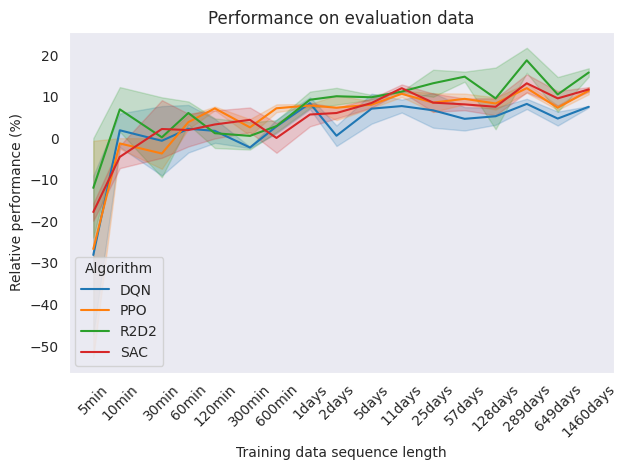

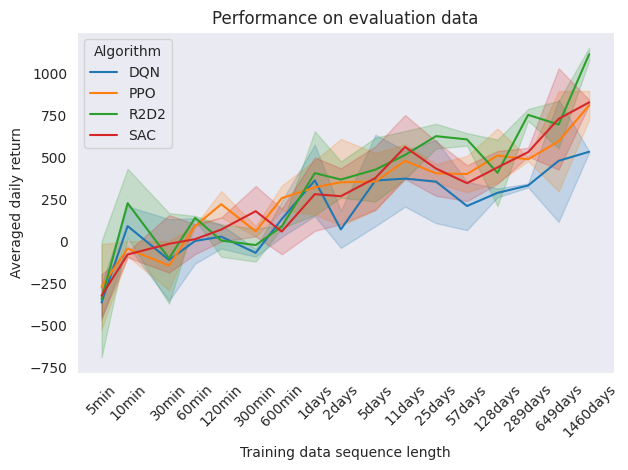

In [23]:
df['normalized_return'] = df['eval_reward'] / df['baseline_reward'] * 100
df['adjusted_return'] = df['eval_reward'] * 1440 / np.clip(df['sequence_len'], 0, 1440)

import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x='sequence_len', y='normalized_return', hue='alg_name', data=df)
plt.xscale('log')
plt.xlabel('Training data sequence length')
plt.ylabel('Relative performance (%)')
plt.title('Performance on evaluation data')
plt.legend(title='Algorithm')
ticks = [5, 10, 30, 60, 120, 300, 600] + (np.geomspace(1, 4 * 365, 10, dtype=int) * 1440).tolist()
labels = [f'{t}min' for t in [5, 10, 30, 60, 120, 300, 600]] + [f'{t}days' for t in np.geomspace(1, 4 * 365, 10, dtype=int)]
plt.xticks(ticks, labels, rotation=45)
plt.grid(False)
plt.tight_layout()
plt.savefig('benchmark_eval_normalized.pdf')
plt.savefig('benchmark_eval_normalized.png')
plt.show()

plt.close()

sns.lineplot(x='sequence_len', y='adjusted_return', hue='alg_name', data=df)
plt.xscale('log')
plt.xlabel('Training data sequence length')
plt.ylabel('Averaged daily return')
plt.title('Performance on evaluation data')
plt.legend(title='Algorithm')
ticks = [5, 10, 30, 60, 120, 300, 600] + (np.geomspace(1, 4 * 365, 10, dtype=int) * 1440).tolist()
labels = [f'{t}min' for t in [5, 10, 30, 60, 120, 300, 600]] + [f'{t}days' for t in np.geomspace(1, 4 * 365, 10, dtype=int)]
plt.xticks(ticks, labels, rotation=45)
plt.grid(False)
plt.tight_layout()
plt.savefig('benchmark_eval_adjusted.pdf')
plt.savefig('benchmark_eval_adjusted.png')
plt.show()

plt.close()

In [25]:
df.to_csv('evaluation_results.csv')

In [34]:
def load_eval_results(path):
    eval_results = []
    with open(path, 'r') as f:
        for line in f:
            data = json.loads(line)
            if 'evaluation' in data:
                eval_results.append(data)

    if len(eval_results) == 0:
        print(path)
    return eval_results

eval_exps = {
    'No fee': '/home/fassty/Devel/school/diploma_thesis/code/exp_results/discrete_env_21ind_normalized/R2D2_stored/R2D2_StockExchangeEnv-v0_bb722_00000_0_2023-05-14_22-56-05/',
    'fee 0.001%': '/home/fassty/Devel/school/diploma_thesis/code/exp_results/discrete_env_21ind_normalized_fee1e-3/R2D2_stored/R2D2_StockExchangeEnv-v0_44106_00000_0_2023-05-16_08-38-32'
}

eval_results = {}
for exp_name, checkpoint_dir in eval_exps.items():
    eval_results[exp_name] = load_eval_results(os.path.join(checkpoint_dir, 'result.json'))

eval_results

{'No fee': [{'evaluation': {'episode_reward_max': 2941.1417108907262,
    'episode_reward_min': -19.17224636627725,
    'episode_reward_mean': 683.7744646286067,
    'episode_len_mean': 1440.0,
    'episode_media': {},
    'episodes_this_iter': 40,
    'policy_reward_min': {},
    'policy_reward_max': {},
    'policy_reward_mean': {},
    'custom_metrics': {},
    'hist_stats': {'episode_reward': [538.7852954954033,
      195.14239409497532,
      292.14632636862734,
      777.2437956344202,
      1310.1563428942773,
      49.200638611358954,
      170.67888298438083,
      2212.790731184794,
      746.4450362505304,
      1746.6109410373083,
      451.1764972386918,
      358.9878422038182,
      254.04967358737485,
      397.3897898490486,
      675.4738395661952,
      817.5211559198142,
      -19.17224636627725,
      1285.357246119349,
      819.0683526397552,
      2941.1417108907262,
      1072.5510049088134,
      320.44899537560923,
      396.73849154693926,
      381.19159696

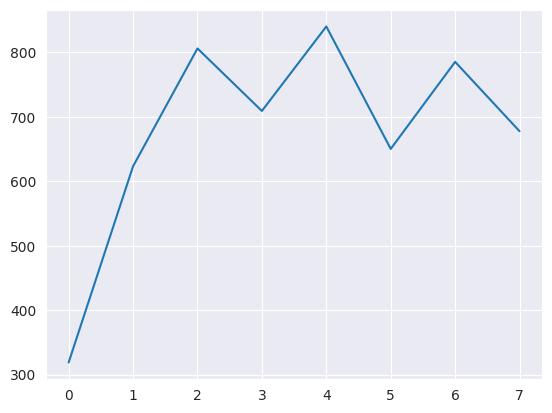

In [35]:
mean_returns = [res['episode_reward_mean'] for res in eval_results['No fee']]

plt.plot(mean_returns)

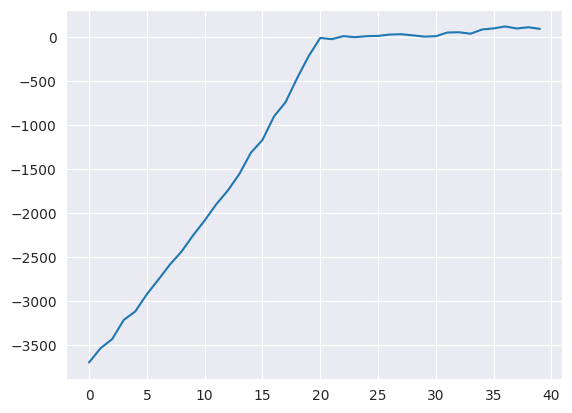

In [36]:
mean_returns = [res['episode_reward_mean'] for res in eval_results['fee 0.001%']]

plt.plot(mean_returns)